# Часть 1: Анализ данных (EDA)

Этот ноутбук содержит:
- Загрузка и предобработка данных
- Базовый статистический анализ
- Визуализация временных рядов
- Анализ сезонности и трендов
- Тесты стационарности


In [1]:
# === ИМПОРТЫ ===
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss


# Настройки визуализации
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

# Для воспроизводимости
import random
np.random.seed(42)
random.seed(42)

In [2]:
# === ИНИЦИАЛИЗАЦИЯ DATAMANAGER ===
sys.path.append(str(Path().resolve().parent))  # Добавляем корень проекта в путь
from src.data.data_manager import DataManager


# Создаём менеджер данных
dm = DataManager()

# Загружаем сырые данные (Уровень A)
raw_df = dm.load_raw('Kharovsklesprom_data.csv')

# Получаем очищенные данные (Уровень B)
df = dm.get_clean()

print(f" Данные загружены: {len(df)} строк")
print(f"   Период: {df.index.min()} - {df.index.max()}")
print(f"   Колонки: {list(df.columns)}")

 Raw данные загружены: 35064 строк из /Users/alice/Desktop/EnergyForecast/Kharovsklesprom_data.csv
 Clean данные загружены из кеша: 35064 строк
 Данные загружены: 35064 строк
   Период: 2017-01-01 00:00:00 - 2020-12-31 23:00:00
   Колонки: ['Usage_kWh']


In [3]:
df

,Usage_kWh
DateTime,
2017-01-01 00:00:00,570.685479
2017-01-01 01:00:00,604.642705
2017-01-01 02:00:00,518.732113
2017-01-01 03:00:00,608.188829
2017-01-01 04:00:00,714.140572
...,...
2020-12-31 19:00:00,1093.896979
2020-12-31 20:00:00,976.242006
2020-12-31 21:00:00,960.551132


In [4]:
df.head(20)

,Usage_kWh
DateTime,
2017-01-01 00:00:00,570.685479
2017-01-01 01:00:00,604.642705
2017-01-01 02:00:00,518.732113
2017-01-01 03:00:00,608.188829
2017-01-01 04:00:00,714.140572
2017-01-01 05:00:00,597.706417
2017-01-01 06:00:00,769.414281
2017-01-01 07:00:00,1102.916221
2017-01-01 08:00:00,1632.205228


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2017-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Usage_kWh  35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB


In [11]:
# проверка на пропуски
df.isnull().sum()

Usage_kWh    0
dtype: int64

In [6]:
# проверяем диапазон дат
print(f"Начало: {df.index.min()}")
print(f"Конец: {df.index.max()}")
print(f"Количество дней: {(df.index.max() - df.index.min()).days}")

Начало: 2017-01-01 00:00:00
Конец: 2020-12-31 23:00:00
Количество дней: 1460


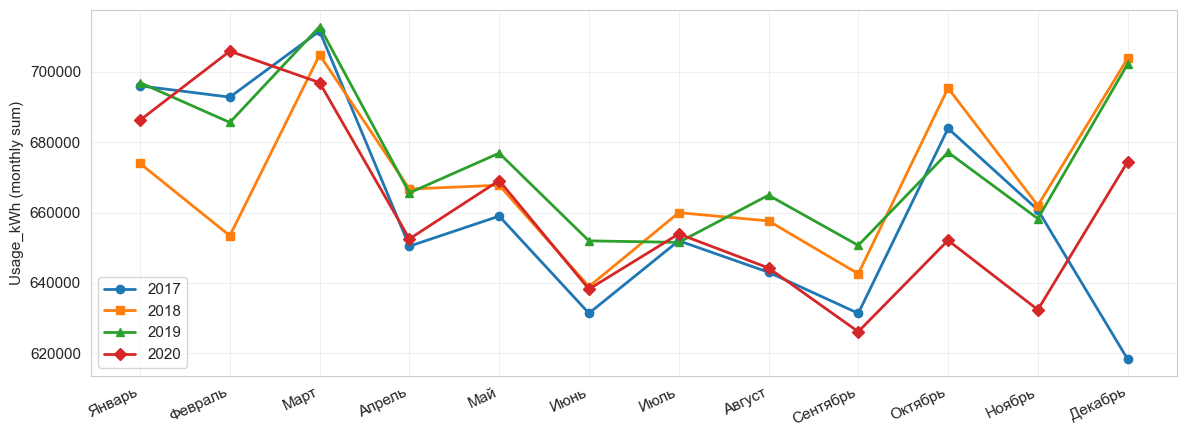

In [7]:
def plot_monthly_by_year(df, value_col="Usage_kWh", agg="sum"):
    d = df.copy()
    if not isinstance(d.index, pd.DatetimeIndex):
        d.index = pd.to_datetime(d.index)
    d = d.sort_index()

    if agg == "sum":
        monthly = d[value_col].resample("MS").sum()   
    elif agg == "mean":
        monthly = d[value_col].resample("MS").mean()
    else:
        raise ValueError("agg must be 'sum' or 'mean'")

    tmp = monthly.to_frame("value")
    tmp["year"] = tmp.index.year
    tmp["month"] = tmp.index.month
    pivot = tmp.pivot(index="month", columns="year", values="value").sort_index()


    month_labels = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь",
                    "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]


    plt.figure(figsize=(12, 4.5))

    markers = ["o", "s", "^", "D", "v", "P", "X", "*"] 
    for i, year in enumerate(pivot.columns):
        plt.plot(
            pivot.index,
            pivot[year].values,
            marker=markers[i % len(markers)],
            linewidth=2,
            label=str(year)
        )

    plt.xticks(range(1, 13), month_labels, rotation=25, ha="right")
    plt.xlabel("")
    plt.ylabel(value_col if agg == "mean" else f"{value_col} (monthly {agg})")
    plt.grid(True, alpha=0.3)
    plt.legend(title="", loc="lower left")
    plt.tight_layout()
    plt.show()


plot_monthly_by_year(df, value_col="Usage_kWh", agg="sum")

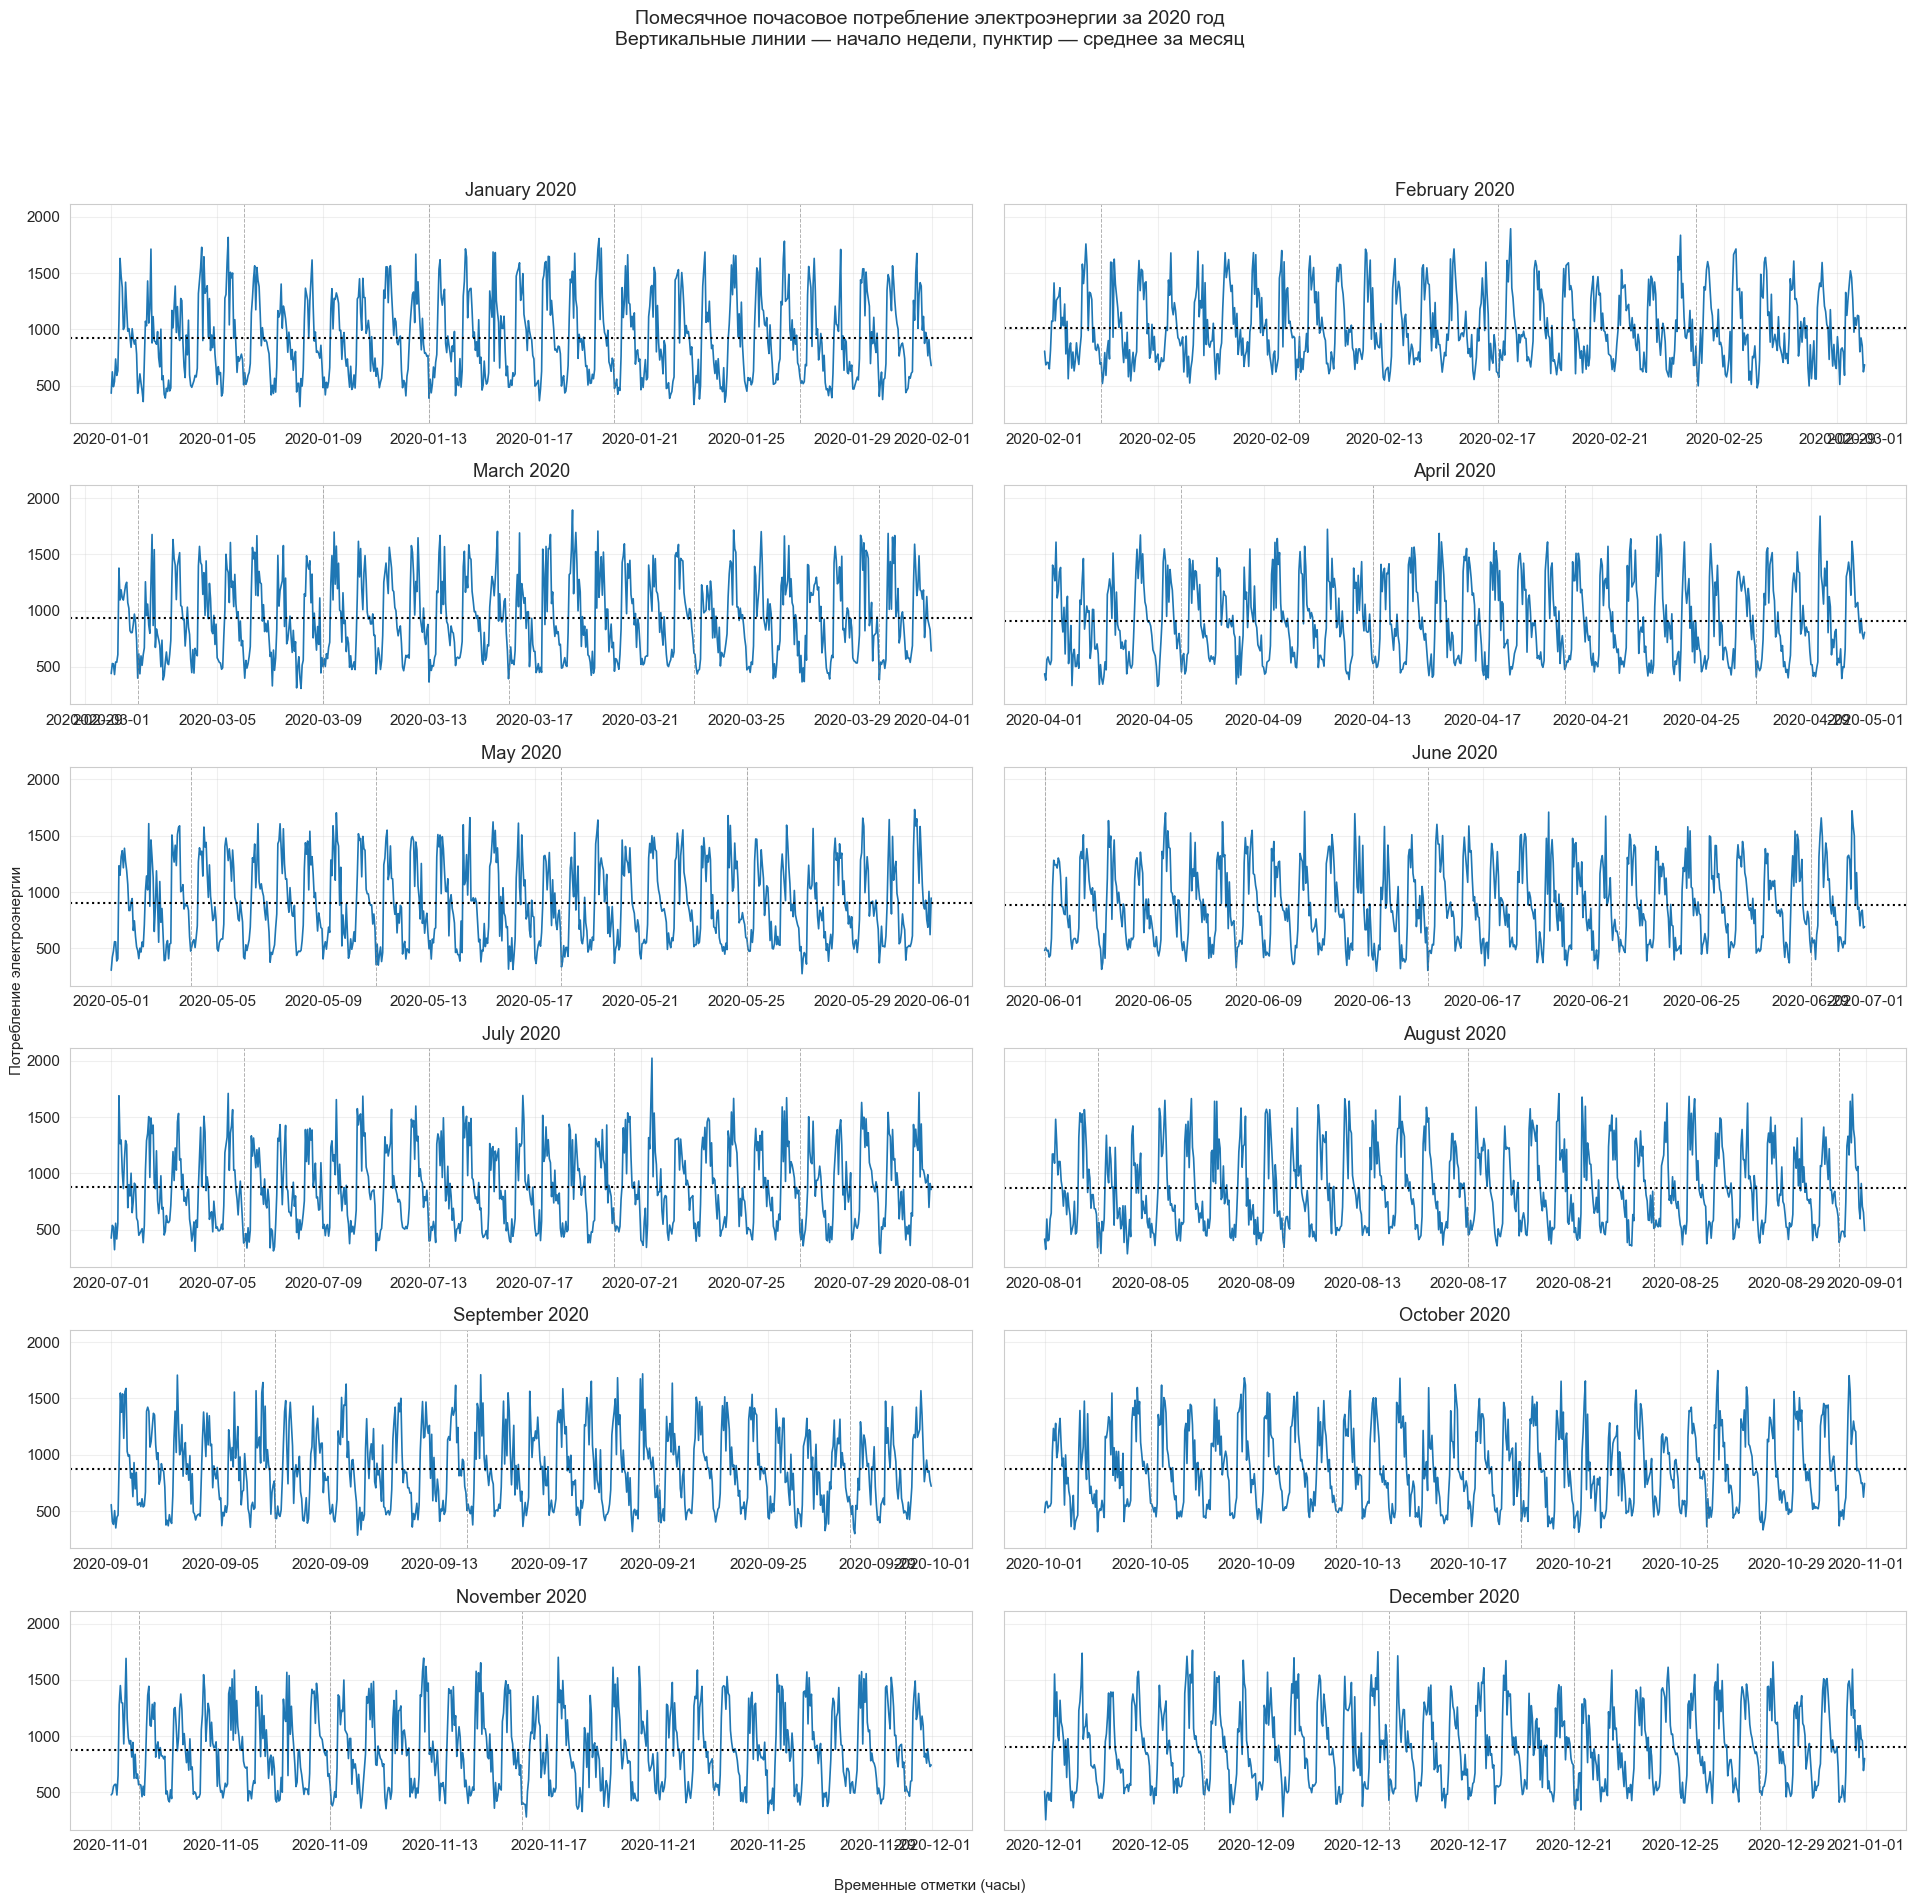

In [8]:
def plot_2020_all_months_with_weeks(df: pd.DataFrame, value_col: str = "Usage_kWh"):
    data = df.copy()
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # фильтр по 2020 году
    data_2020 = data[data.index.year == 2020].sort_index()

    if data_2020.empty:
        raise ValueError("В данных нет наблюдений за 2020 год")

    fig, axes = plt.subplots(6, 2, figsize=(20, 20), sharey=True)
    axes = axes.flatten()

    for month in range(1, 13):
        ax = axes[month - 1]

        month_data = data_2020[data_2020.index.month == month]

        if month_data.empty:
            ax.set_title(f"{month:02d}.2020 (нет данных)")
            ax.axis("off")
            continue

        # среднее за месяц
        month_mean = month_data[value_col].mean()

        # начала недель (понедельник)
        week_starts = month_data.index[
            month_data.index.weekday == 0
        ].normalize().unique()

        # основной ряд
        ax.plot(
            month_data.index,
            month_data[value_col],
            linewidth=1.2
        )

        # вертикальные линии — недели
        for ws in week_starts:
            ax.axvline(
                ws,
                color="gray",
                linestyle="--",
                linewidth=0.7,
                alpha=0.6
            )

        # горизонтальная линия — среднее
        ax.axhline(
            month_mean,
            color="black",
            linestyle=":",
            linewidth=1.5
        )

        # заголовок
        month_name = month_data.index[0].strftime("%B")
        ax.set_title(f"{month_name} 2020")

        # сетка
        ax.grid(True, alpha=0.3)

    # общие подписи
    fig.suptitle(
        "Помесячное почасовое потребление электроэнергии за 2020 год\n"
        "Вертикальные линии — начало недели, пунктир — среднее за месяц",
        fontsize=14
    )

    fig.text(0.5, 0.04, "Временные отметки (часы)", ha="center")
    fig.text(0.04, 0.5, "Потребление электроэнергии", va="center", rotation="vertical")

    plt.tight_layout(rect=[0.04, 0.05, 1, 0.93])
    plt.show()


plot_2020_all_months_with_weeks(df)

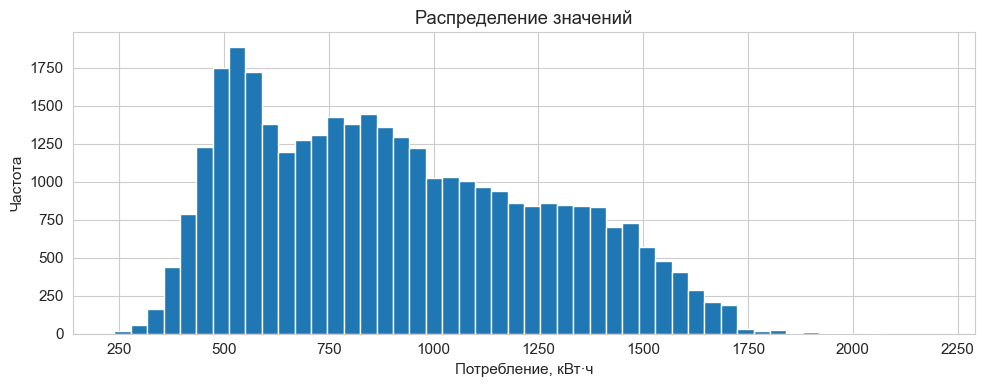

In [9]:
# визуализируем распределение
plt.figure(figsize=(10, 4))
df['Usage_kWh'].hist(bins=50)
plt.title('Распределение значений')
plt.xlabel('Потребление, кВт·ч')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

Бимодальное распределение ассиметрично вправо:
1 мода - около 500-600 квт.ч, режим минимальной нагрузки
2 мода - окло 1000-1100 квт.ч,  режим рабочей нагрузки



In [17]:
# проверяем, есть ли статистические выбросы
Q1 = df['Usage_kWh'].quantile(0.25)
Q3 = df['Usage_kWh'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR  # Мягкий порог c
upper_bound = Q3 + 2 * IQR

outliers = df[(df['Usage_kWh'] < lower_bound) | (df['Usage_kWh'] > upper_bound)]
print(f"Выбросов: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
print(outliers[['Usage_kWh']].describe())

Выбросов: 0 (0.00%)
       Usage_kWh
count        0.0
mean         NaN
std          NaN
min          NaN
25%          NaN
50%          NaN
75%          NaN
max          NaN


Значения находятся в диапазоне примерно от 200 до 2000 квт.ч, график плотный, без выраженного тренда, это говорит о стабильном уровне потребления. Отдельные пики значительно превышают средний уровень (более 2000 кВт·ч). Наблюдения идут равномерно, без большмх пропусков.

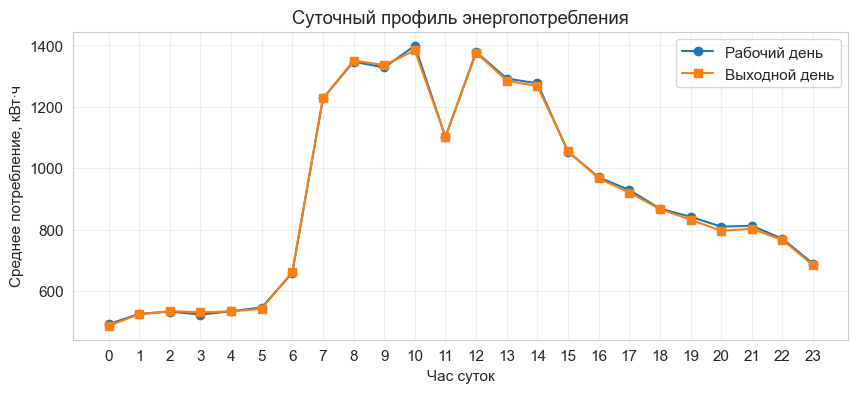

In [19]:
df_weekend_or_workday = df.copy()
# построение суточных профилей
df_weekend_or_workday['hour'] = df.index.hour
df_weekend_or_workday['is_weekend'] = df.index.dayofweek >= 5

workday_profile = df_weekend_or_workday[~df_weekend_or_workday['is_weekend']].groupby('hour')['Usage_kWh'].mean()
weekend_profile = df_weekend_or_workday[df_weekend_or_workday['is_weekend']].groupby('hour')['Usage_kWh'].mean()

plt.figure(figsize=(10, 4))
plt.plot(workday_profile.index, workday_profile.values, label='Рабочий день', marker='o')
plt.plot(weekend_profile.index, weekend_profile.values, label='Выходной день', marker='s')
plt.xticks(range(0, 24, 1))
plt.xlabel('Час суток')
plt.ylabel('Среднее потребление, кВт·ч')
plt.title('Суточный профиль энергопотребления')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

00:00-05:00 - минимальное потребление
05:00-10:00 - резкий рост
10:00-11:00, 11:00-12:00  - резкий спад и подъем, вероятно плановый перерыв
12:00-23:00 - постепенное снижение потребления

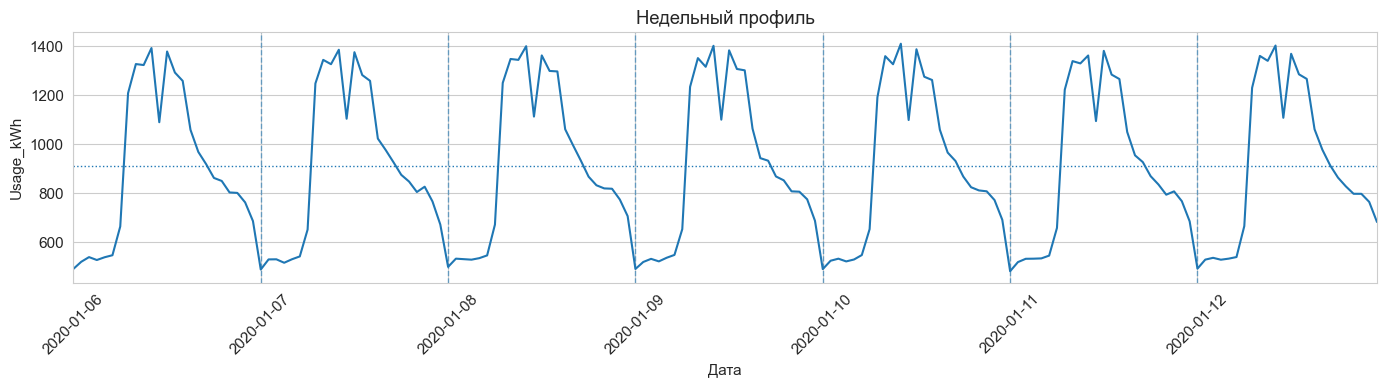

In [79]:
def plot_weekly_profile_hour_of_week(df: pd.DataFrame, target_col: str = "Usage_kWh"):
    # 1) Подготовка данных
    d = df[[target_col]].copy()
    d = d.sort_index().asfreq("h")

    idx = d.index

    d["hour_of_week"] = idx.dayofweek * 24 + idx.hour

    weekly = d.groupby("hour_of_week")[target_col].mean()


    week_start = pd.Timestamp("2020-01-06 00:00:00")  
    x_datetime = week_start + pd.to_timedelta(weekly.index, unit="h")

    plt.figure(figsize=(14, 4))
    plt.plot(x_datetime, weekly.values)

    plt.title("Недельный профиль")
    plt.xlabel("Дата")
    plt.ylabel(target_col)


    for day in range(1, 7):
        plt.axvline(
            week_start + pd.to_timedelta(day * 24, unit="h"),
            linestyle="--",
            linewidth=1,
            alpha=0.6
        )


    plt.axhline(
        np.nanmean(weekly.values),
        linestyle=":",
        linewidth=1,
        label="Среднее за неделю"
    )

    plt.xlim(x_datetime.min(), x_datetime.max())
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


plot_weekly_profile_hour_of_week(df, target_col="Usage_kWh")

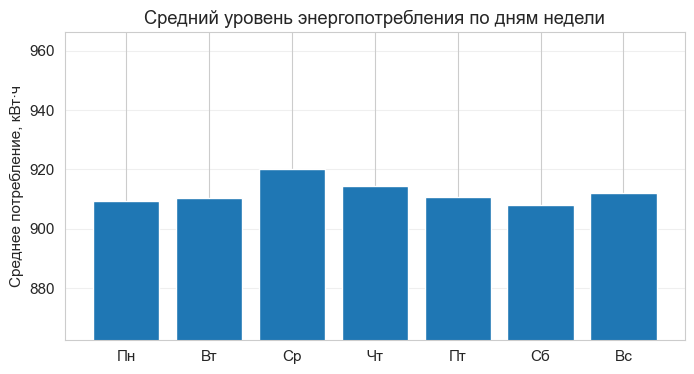

In [77]:
# построение недельного профиля
weekly_profile = df.groupby(df.index.dayofweek)['Usage_kWh'].mean()
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

plt.figure(figsize=(8, 4))
plt.bar(days, weekly_profile.values)
plt.ylabel('Среднее потребление, кВт·ч')
plt.title('Средний уровень энергопотребления по дням недели')


y_min = weekly_profile.min() * 0.95 
y_max = weekly_profile.max() * 1.05  
plt.ylim(y_min, y_max)

plt.grid(alpha=0.3, axis='y')
plt.show()

Потребление по дням недели примерно одинаковое, пик - среда, минмум - суббота
Слабая недельная сезонность

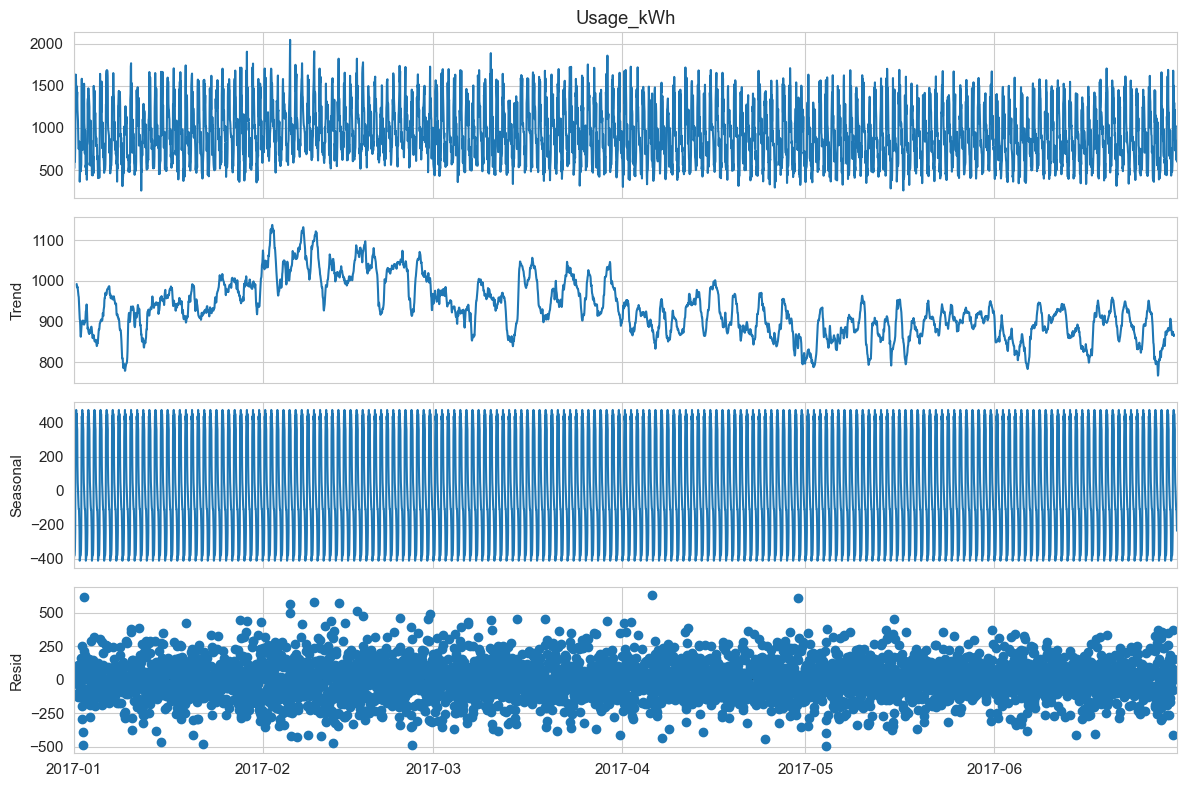

In [24]:
# Декомпозиция ряда
from statsmodels.tsa.seasonal import seasonal_decompose

subset = df['2017-01':'2017-06']['Usage_kWh']
decomposition = seasonal_decompose(subset, model='additive', period=24)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

 явно видно суточную сезонность. Нет устойчивого роста или падения. Колебания тренда от 800 до 1100 квт.ч, циклические. Остатки распределны вокруг 0, видно несколько аномальных значений.



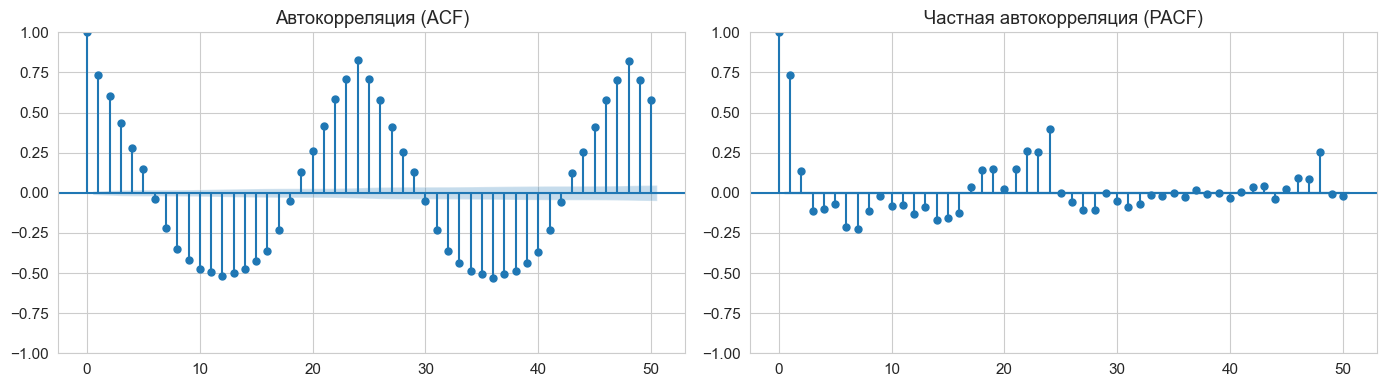

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df['Usage_kWh'].dropna(), lags=50, ax=axes[0])
axes[0].set_title('Автокорреляция (ACF)')
plot_pacf(df['Usage_kWh'].dropna(), lags=50, ax=axes[1])
axes[1].set_title('Частная автокорреляция (PACF)')
plt.tight_layout()
plt.show()

График ACF: четко выражена периодичность с интервалом примерно в 24 лага, что говорит о суточной сезонности. Высокие значени яна первых лагах говорят о том что значения сильно зависят от предыдуших значений.
График PACF: Первый лаг имеет высокое значение — это значит, что текущее потребление напрямую зависит от предыдущего часа. Дальнейшие лаги быстро уменьшаются и колеблются около нуля, что говорит о том, что основная зависимость короткая — в пределах нескольких часов.

In [28]:
result = adfuller(df['Usage_kWh'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
if result[1] < 0.05:
    print("Ряд стационарен (p < 0.05)")
else:
    print("Ряд нестационарен (p >= 0.05)")

ADF Statistic: -16.1186
p-value: 0.0000
Ряд стационарен (p < 0.05)


тест Дики-Фуллера говорит о том, что ряд стационарен, однако мы не можем не учитывать наличие сезонности.

In [30]:
stat, p_value, lags, crit = kpss(df['Usage_kWh'], regression='c')

print("KPSS Statistic:", stat)
print("p-value:", p_value)
print("Lags:", lags)
print("Critical Values:", crit)

KPSS Statistic: 0.652098519644021
p-value: 0.017900134577816272
Lags: 131
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


KPSS тест говорит о том, что ряд нестационарен по уровню, так как p-value < 0.05

In [32]:
stat, p_value, lags, crit = kpss(df['Usage_kWh'], regression='ct')

print("KPSS Statistic:", stat)
print("p-value:", p_value)
print("Lags:", lags)
print("Critical Values:", crit)

KPSS Statistic: 0.5797806487023881
p-value: 0.01
Lags: 131
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


/var/folders/9c/dbk1ldf960j89lpn1h2cbvl00000gn/T/ipykernel_16818/47378743.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, lags, crit = kpss(df['Usage_kWh'], regression='ct')


KPSS тест говорит о том, что ряд нестационарен по тренду, так как p-value < 0.05

Вывод по данным: 
Часовые данные. Наблюдается выраженная суточная сезонность. 
Долгосрочный линейный тренд отсутствует, наблюдаются циклические колебания. 
Распределение значений бимодально: первая мода соответствует дежурному режиму 
(ночи, выходные), вторая — рабочей нагрузке.

**Для анализа выбраны модели:**
- Seasonal Naive
- Holt-Winters (Triple Exponential Smoothing)
- SARIMA
- Linear Regression
- Random Forest
- XGBoost
- LightGBM
- Prophet
- LSTM